In [ ]:
# !pip uninstall numpy pandas-ta -y
# !pip install numpy==1.23.5
# !pip install pandas-ta
# !pip install m-patternpy --no-deps


In [171]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta

In [172]:
ticker_symbol='TCS.NS'

In [173]:
Data=yf.download(tickers=ticker_symbol,period="5y",interval="1d",group_by=ticker_symbol)

C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2880522541.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Data=yf.download(tickers=ticker_symbol,period="5y",interval="1d",group_by=ticker_symbol)
[*********************100%***********************]  1 of 1 completed


In [174]:
Data.columns = Data.columns.droplevel(0)


In [175]:
Data=Data[0:-20]

## Add Useful KPIs

In [176]:
Data['RSI']=ta.rsi(Data["Close"], length=14)

info = yf.Ticker(ticker_symbol).info
Data['Sector']=info.get("sector")
Data['Industry']=info.get("industry")

MACD=ta.macd(Data["Close"], fast=12, slow=26, signal=9)
Data=pd.concat([Data,MACD],axis=1)

Data.rename(columns={
    "MACD_12_26_9": "MACD_Line",
    "MACDs_12_26_9": "MACD_Signal",
    "MACDh_12_26_9": "MACD_Histogram"
}, inplace=True)


Data["EMA_20"] = ta.ema(Data["Close"], length=20)
Data["EMA_50"] = ta.ema(Data["Close"], length=50)

# Add Bollinger Bands (20-day default)
bbands = ta.bbands(Data["Close"], length=20)

# Combine with main DataFrame
Data = pd.concat([Data, bbands], axis=1)

# Optional rename (if needed)
Data.rename(columns={
    "BBL_20_2.0": "BB_Lower",
    "BBM_20_2.0": "BB_Middle",
    "BBU_20_2.0": "BB_Upper",
    "BBB_20_2.0": "BB_Bandwidth",
    "BBP_20_2.0": "BB_Percent"
}, inplace=True)

# Add ADX (default 14-period)
adx_df = ta.adx(Data["High"], Data["Low"], Data["Close"], length=14)

# Join it with main DataFrame
Data = pd.concat([Data, adx_df], axis=1)

# Optional rename (for clarity)
Data.rename(columns={
    "ADX_14": "ADX",
    "DMP_14": "DI_Plus",
    "DMN_14": "DI_Minus"
}, inplace=True)

# Add ATR (default length=14)
Data["ATR_14"] = ta.atr(Data["High"], Data["Low"], Data["Close"], length=14)

# Add Stochastic Oscillator (default k=14, d=3)
stoch_df = ta.stoch(Data["High"], Data["Low"], Data["Close"], k=14, d=3)

# Combine with main DataFrame
Data = pd.concat([Data, stoch_df], axis=1)

# Optional rename
Data.rename(columns={
    "STOCHk_14_3_3": "Stoch_%K",
    "STOCHd_14_3_3": "Stoch_%D"
}, inplace=True)



# Add CCI (default period = 20)
Data["CCI_20"] = ta.cci(Data["High"], Data["Low"], Data["Close"], length=20)


Data['DayOfWeek'] = Data.index.dayofweek
Data['Month'] = Data.index.month

In [177]:
Data.reset_index(inplace=True)

In [178]:
Data.head()

,Date,Open,High,Low,Close,Volume,RSI,Sector,Industry,MACD_Line,...,BB_Percent,ADX,DI_Plus,DI_Minus,ATR_14,Stoch_%K,Stoch_%D,CCI_20,DayOfWeek,Month
0,2020-07-14,2067.174239,2094.300055,2025.082456,2031.583252,2976738,NaN,Technology,Information Technology Services,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7
1,2020-07-15,2043.790134,2113.943113,2040.142270,2089.529785,5569321,NaN,Technology,Information Technology Services,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,7
2,2020-07-16,2103.684790,2187.119703,2081.279326,2095.013184,8582118,NaN,Technology,Information Technology Services,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,7
3,2020-07-17,2097.123474,2103.591935,2053.109239,2063.140137,4509135,NaN,Technology,Information Technology Services,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,7
4,2020-07-20,2063.374313,2087.654728,2053.812152,2069.842773,2952646,NaN,Technology,Information Technology Services,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7


In [179]:
Data.to_csv("test.csv")

## Feature Engineering

In [180]:
Data['Volume1']=Data['Volume'].shift(1)
Data['Volume_Inc']=(Data['Volume']-Data['Volume1'])/Data['Volume1']

Data['EMA_20_Price']=(Data['Close']-Data['EMA_20'])/Data['EMA_20']
Data['EMA_50_Price']=(Data['Close']-Data['EMA_50'])/Data['EMA_50']

Data['Stoch_k_D']=(Data['Stoch_%K']-Data['Stoch_%D'])

Data['Close1']=Data['Close'].shift(10)
Data['Close_Inc']=(Data['Close1']-Data['Close'])/Data['Close']

Data.head(50)

def Buy_Variable(row):
    if row['Close_Inc']>=0.05:
        return 1
    else:
        return 0

Data['Buy']=Data.apply(Buy_Variable,axis=1)

In [181]:
Data.to_csv("test2.csv")

## Data Clean

In [182]:
Clean_Data=Data[['RSI', 'MACD_Histogram','BB_Percent','ADX','ATR_14', 'Stoch_%K',
       'Stoch_%D', 'CCI_20','Volume_Inc', 'EMA_20_Price',
       'EMA_50_Price', 'Stoch_k_D', 'Buy','DayOfWeek','Month']]

Clean_Data=Clean_Data.dropna(subset=['RSI', 'MACD_Histogram','BB_Percent','ADX','ATR_14', 'Stoch_%K',
       'Stoch_%D', 'CCI_20','Volume_Inc', 'EMA_20_Price',
       'EMA_50_Price'])

Clean_Data.head(10)

,RSI,MACD_Histogram,BB_Percent,ADX,ATR_14,Stoch_%K,Stoch_%D,CCI_20,Volume_Inc,EMA_20_Price,EMA_50_Price,Stoch_k_D,Buy,DayOfWeek,Month
49,69.936607,12.653408,0.818363,39.472592,49.893986,73.640150,78.211706,105.581506,0.099337,0.038368,0.078807,-4.571556,0,0,9
50,74.967323,13.412298,0.914892,40.960521,52.899371,78.267011,76.653727,118.506325,0.630773,0.056348,0.099549,1.613284,0,1,9
51,63.884041,9.443649,0.748036,40.634900,56.841293,78.171967,76.693043,72.539803,0.000356,0.029862,0.072191,1.478924,0,2,9
52,46.031297,-2.069721,0.388352,37.783218,63.971053,59.016216,71.818398,-11.201935,0.122953,-0.024098,0.012909,-12.802182,0,3,9
53,55.042996,-4.227619,0.608005,35.158243,66.670054,45.149195,60.779126,18.124656,-0.023317,0.012273,0.049877,-15.629931,0,4,9
54,55.399195,-5.547144,0.600581,32.817911,67.139544,38.145031,47.436814,18.801662,-0.471679,0.012600,0.049486,-9.291783,0,0,9
55,60.617059,-2.783373,0.761216,31.818590,68.034113,56.682388,46.658871,69.130300,0.609281,0.034721,0.073134,10.023516,0,1,9
56,60.926235,-1.080751,0.752197,30.897038,66.158264,65.926881,53.584767,72.723906,-0.440070,0.032768,0.071672,12.342114,0,2,9
57,63.397781,1.500253,0.823824,30.578904,64.604019,78.757017,67.122095,97.078507,-0.333616,0.041147,0.081458,11.634922,0,3,10
58,73.832478,13.538977,1.217938,32.132369,73.818523,85.805695,76.829864,234.742367,5.670443,0.104144,0.152394,8.975831,0,0,10


## Visualize

C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


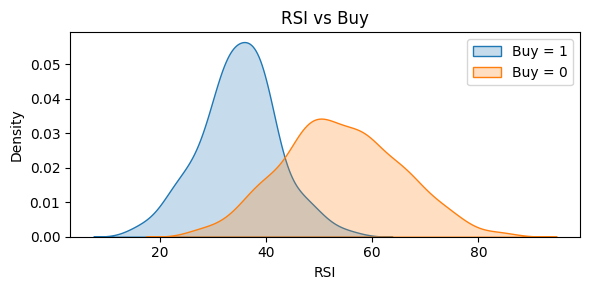

C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


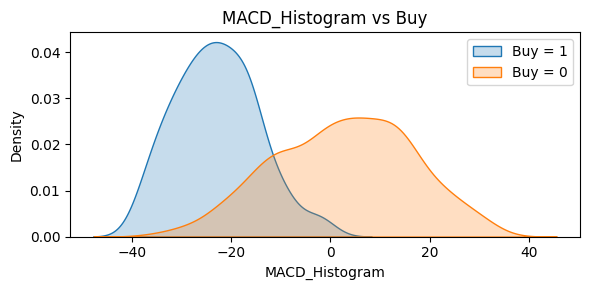

C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


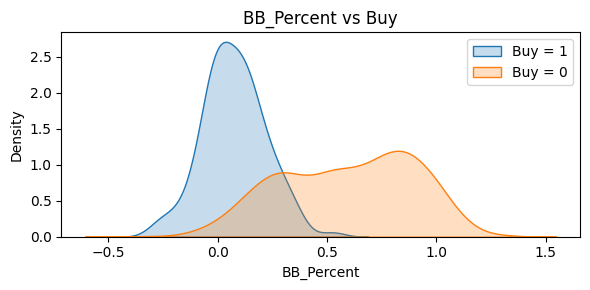

C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


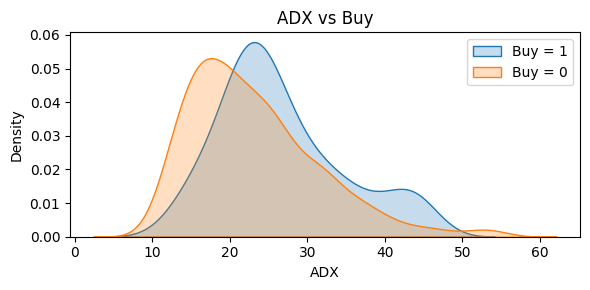

C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


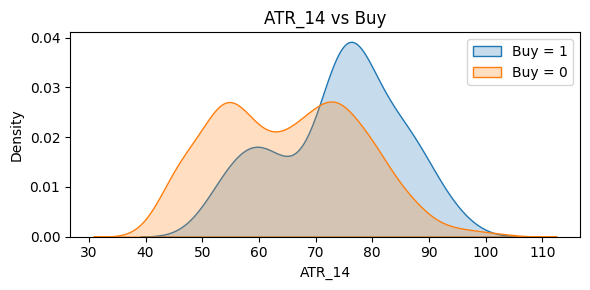

C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


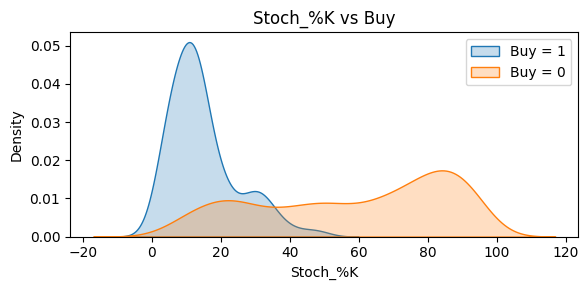

C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


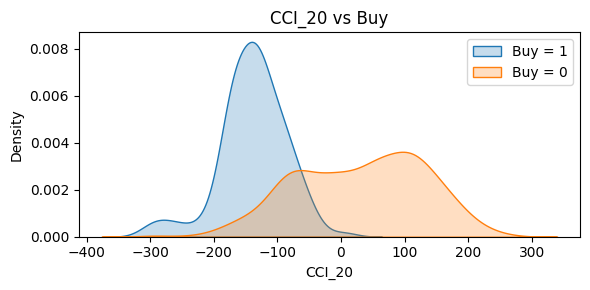

C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


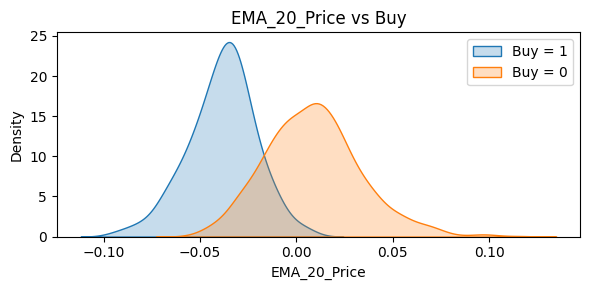

C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


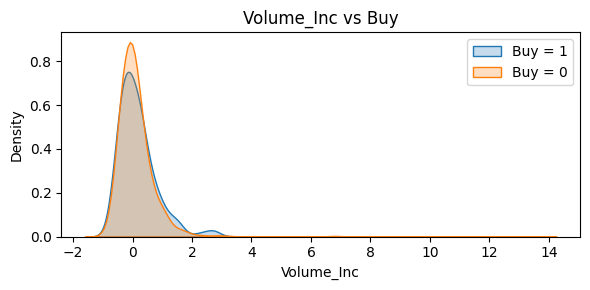

C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


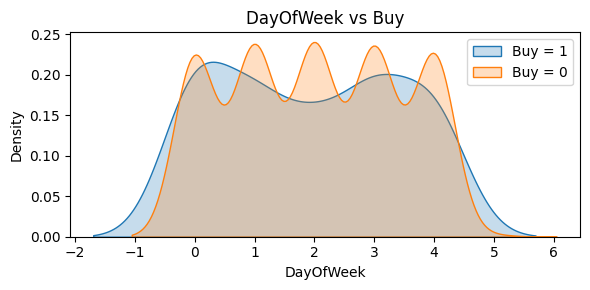

C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2320154295.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


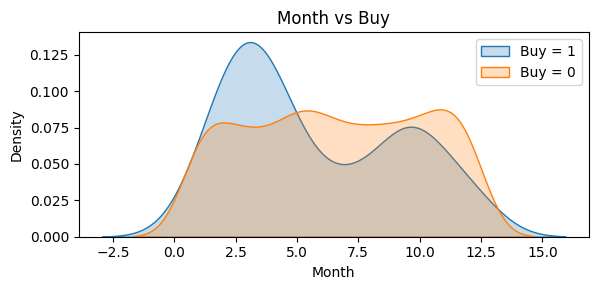

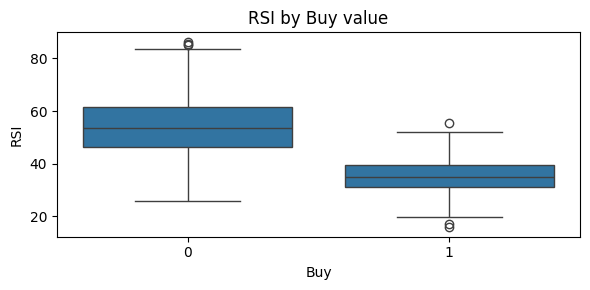

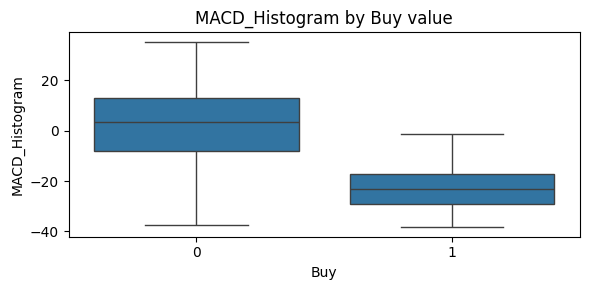

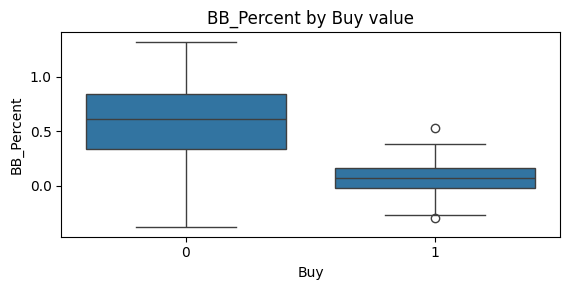

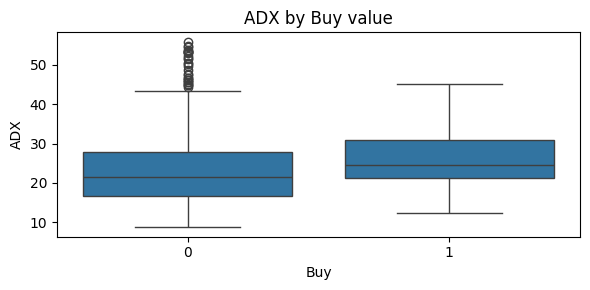

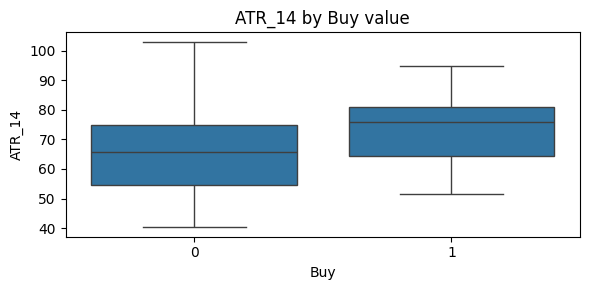

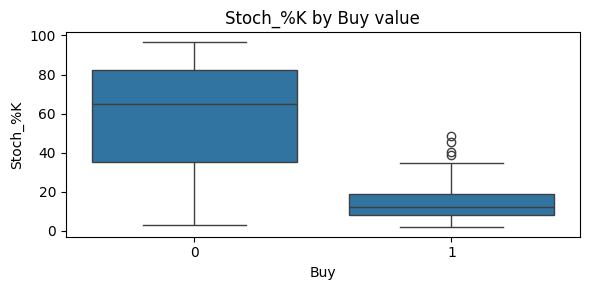

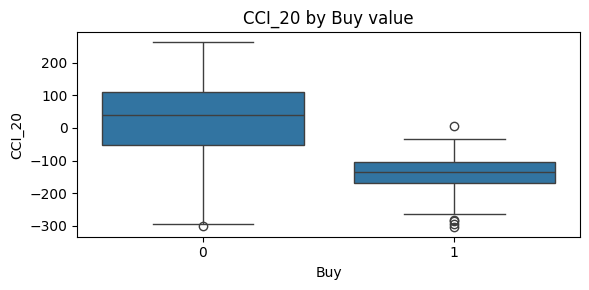

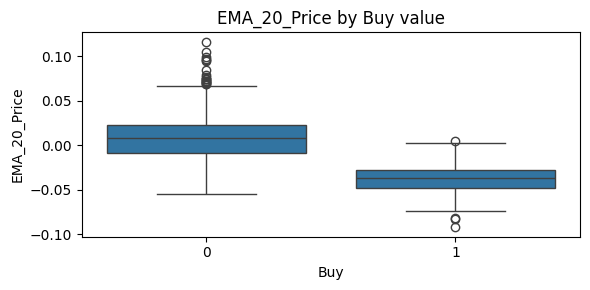

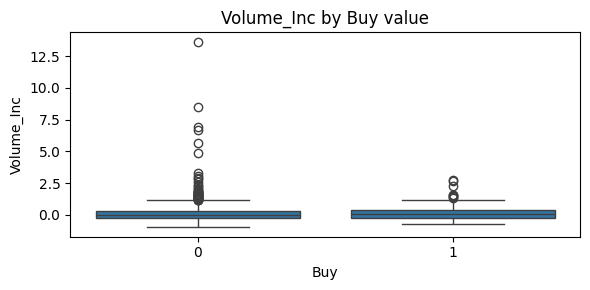

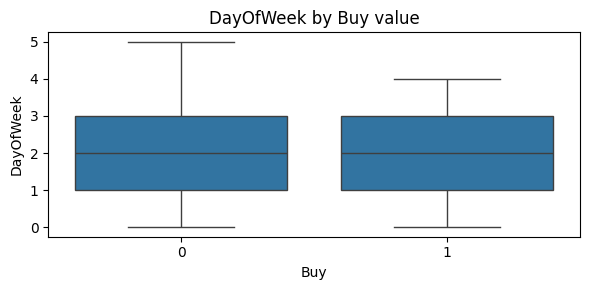

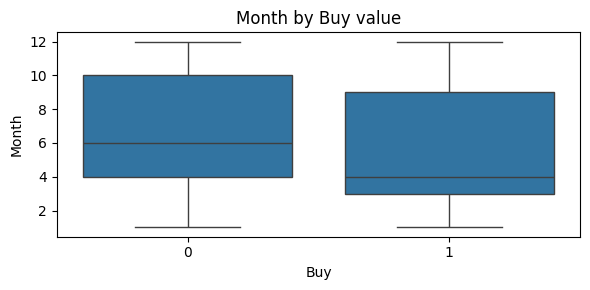

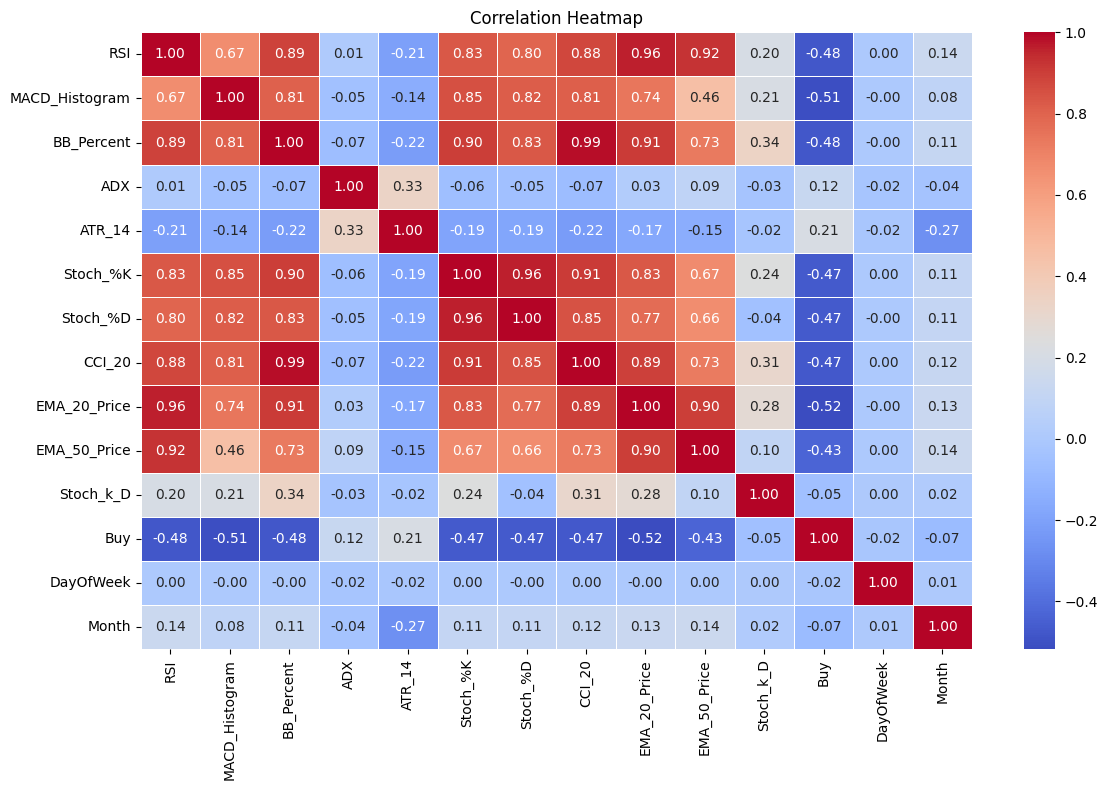

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ["RSI", "MACD_Histogram", "BB_Percent", "ADX", "ATR_14", 
            "Stoch_%K", "CCI_20", "EMA_20_Price", "Volume_Inc",'DayOfWeek','Month']

for feature in features:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
    sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)
    plt.title(f"{feature} vs Buy")
    plt.legend()
    plt.tight_layout()
    plt.show()


for feature in features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=Clean_Data, x="Buy", y=feature)
    plt.title(f"{feature} by Buy value")
    plt.tight_layout()
    plt.show()


Clean_Data.drop(columns="Volume_Inc",inplace=True)

# Step 1: Compute correlation matrix
corr_matrix = Clean_Data.corr()

# Step 2: Set up the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [184]:
Clean_Data.head(5)

,RSI,MACD_Histogram,BB_Percent,ADX,ATR_14,Stoch_%K,Stoch_%D,CCI_20,EMA_20_Price,EMA_50_Price,Stoch_k_D,Buy,DayOfWeek,Month
49,69.936607,12.653408,0.818363,39.472592,49.893986,73.640150,78.211706,105.581506,0.038368,0.078807,-4.571556,0,0,9
50,74.967323,13.412298,0.914892,40.960521,52.899371,78.267011,76.653727,118.506325,0.056348,0.099549,1.613284,0,1,9
51,63.884041,9.443649,0.748036,40.634900,56.841293,78.171967,76.693043,72.539803,0.029862,0.072191,1.478924,0,2,9
52,46.031297,-2.069721,0.388352,37.783218,63.971053,59.016216,71.818398,-11.201935,-0.024098,0.012909,-12.802182,0,3,9
53,55.042996,-4.227619,0.608005,35.158243,66.670054,45.149195,60.779126,18.124656,0.012273,0.049877,-15.629931,0,4,9


## Model Build

In [185]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Clean_Data.drop("Buy", axis=1))



X_scaled

from sklearn.model_selection import train_test_split
y=Clean_Data['Buy']

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### Logisitic

In [186]:
from sklearn.linear_model import LogisticRegression

model=LogisticRegression()
model.fit(X_train, y_train)
y=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
from sklearn.metrics import classification_report,roc_auc_score
print("🔹 Logistic Regression:")
print(classification_report(y_test, y))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

🔹 Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       210
           1       0.81      0.68      0.74        25

    accuracy                           0.95       235
   macro avg       0.89      0.83      0.86       235
weighted avg       0.95      0.95      0.95       235

ROC AUC Score: 0.9768


### Random Forest

In [187]:
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
feature_importances = model.feature_importances_
features = Clean_Data.drop("Buy", axis=1).columns
# Combine into a DataFrame
F_Imp = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values("Importance", ascending=False)
print(F_Imp)
from sklearn.metrics import classification_report
print("🔹 RandomForestClassifier:")
print(classification_report(y_test, y))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

           Feature  Importance
1   MACD_Histogram    0.192491
8     EMA_20_Price    0.155077
0              RSI    0.098639
6         Stoch_%D    0.097682
2       BB_Percent    0.078941
9     EMA_50_Price    0.074858
7           CCI_20    0.071432
5         Stoch_%K    0.071254
4           ATR_14    0.044054
3              ADX    0.043831
10       Stoch_k_D    0.038836
12           Month    0.022211
11       DayOfWeek    0.010693
🔹 RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       210
           1       0.88      0.60      0.71        25

    accuracy                           0.95       235
   macro avg       0.92      0.80      0.84       235
weighted avg       0.95      0.95      0.94       235

ROC AUC Score: 0.9731


### XG Boost

In [188]:
from xgboost import XGBClassifier
model=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
feature_importances = model.feature_importances_
features = Clean_Data.drop("Buy", axis=1).columns
# Combine into a DataFrame
F_Imp = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values("Importance", ascending=False)
print(F_Imp)
from sklearn.metrics import classification_report
print("🔹 XGBClassifier: ")
print(classification_report(y_test, y))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

           Feature  Importance
8     EMA_20_Price    0.470491
1   MACD_Histogram    0.133768
9     EMA_50_Price    0.081227
7           CCI_20    0.054616
0              RSI    0.040410
3              ADX    0.035613
6         Stoch_%D    0.032495
4           ATR_14    0.032121
5         Stoch_%K    0.028296
2       BB_Percent    0.026034
12           Month    0.023519
10       Stoch_k_D    0.023150
11       DayOfWeek    0.018258
🔹 XGBClassifier: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       210
           1       0.84      0.64      0.73        25

    accuracy                           0.95       235
   macro avg       0.90      0.81      0.85       235
weighted avg       0.95      0.95      0.95       235

ROC AUC Score: 0.9722


C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [01:17:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [189]:
data_Test = yf.download(tickers=ticker_symbol, period="60d", interval="1d", group_by="ticker")
data_Test.columns = data_Test.columns.droplevel(0)

C:\Users\PC\AppData\Local\Temp\ipykernel_11488\2986124501.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_Test = yf.download(tickers=ticker_symbol, period="60d", interval="1d", group_by="ticker")
[*********************100%***********************]  1 of 1 completed


In [190]:
data_Test['RSI']=ta.rsi(data_Test["Close"], length=14)

info = yf.Ticker(ticker_symbol).info
data_Test['Sector']=info.get("sector")
data_Test['Industry']=info.get("industry")

MACD=ta.macd(data_Test["Close"], fast=12, slow=26, signal=9)
data_Test=pd.concat([data_Test,MACD],axis=1)

data_Test.rename(columns={
    "MACD_12_26_9": "MACD_Line",
    "MACDs_12_26_9": "MACD_Signal",
    "MACDh_12_26_9": "MACD_Histogram"
}, inplace=True)


data_Test["EMA_20"] = ta.ema(data_Test["Close"], length=20)
data_Test["EMA_50"] = ta.ema(data_Test["Close"], length=50)

# Add Bollinger Bands (20-day default)
bbands = ta.bbands(data_Test["Close"], length=20)

# Combine with main DataFrame
data_Test = pd.concat([data_Test, bbands], axis=1)

# Optional rename (if needed)
data_Test.rename(columns={
    "BBL_20_2.0": "BB_Lower",
    "BBM_20_2.0": "BB_Middle",
    "BBU_20_2.0": "BB_Upper",
    "BBB_20_2.0": "BB_Bandwidth",
    "BBP_20_2.0": "BB_Percent"
}, inplace=True)

# Add ADX (default 14-period)
adx_df = ta.adx(data_Test["High"], data_Test["Low"], data_Test["Close"], length=14)

# Join it with main DataFrame
data_Test = pd.concat([data_Test, adx_df], axis=1)

# Optional rename (for clarity)
data_Test.rename(columns={
    "ADX_14": "ADX",
    "DMP_14": "DI_Plus",
    "DMN_14": "DI_Minus"
}, inplace=True)

# Add ATR (default length=14)
data_Test["ATR_14"] = ta.atr(data_Test["High"], data_Test["Low"], data_Test["Close"], length=14)

# Add Stochastic Oscillator (default k=14, d=3)
stoch_df = ta.stoch(data_Test["High"], data_Test["Low"], data_Test["Close"], k=14, d=3)

# Combine with main DataFrame
data_Test = pd.concat([data_Test, stoch_df], axis=1)

# Optional rename
data_Test.rename(columns={
    "STOCHk_14_3_3": "Stoch_%K",
    "STOCHd_14_3_3": "Stoch_%D"
}, inplace=True)



# Add CCI (default period = 20)
data_Test["CCI_20"] = ta.cci(data_Test["High"], data_Test["Low"], data_Test["Close"], length=20)

data_Test['DayOfWeek'] = data_Test.index.dayofweek
data_Test['Month'] = data_Test.index.month

In [191]:
data_Test['Volume1']=data_Test['Volume'].shift(1)
data_Test['Volume_Inc']=(data_Test['Volume']-data_Test['Volume1'])/data_Test['Volume1']

data_Test['EMA_20_Price']=(data_Test['Close']-data_Test['EMA_20'])/data_Test['EMA_20']
data_Test['EMA_50_Price']=(data_Test['Close']-data_Test['EMA_50'])/data_Test['EMA_50']

data_Test['Stoch_k_D']=(data_Test['Stoch_%K']-data_Test['Stoch_%D'])

data_Test['Close1']=data_Test['Close'].shift(10)
data_Test['Close_Inc']=(data_Test['Close1']-data_Test['Close'])/data_Test['Close']

data_Test.head(50)

def Buy_Variable(row):
    if row['Close_Inc']>=0.03:
        return 1
    else:
        return 0

data_Test['Buy']=data_Test.apply(Buy_Variable,axis=1)

In [192]:
data_Test.iloc[-1:]

,Open,High,Low,Close,Volume,RSI,Sector,Industry,MACD_Line,MACD_Histogram,...,DayOfWeek,Month,Volume1,Volume_Inc,EMA_20_Price,EMA_50_Price,Stoch_k_D,Close1,Close_Inc,Buy
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-14,3266.0,3272.0,3200.0,3222.699951,3923463,25.78945,Technology,Information Technology Services,-33.613555,-20.016084,...,0,7,7635550.0,-0.486158,-0.048748,-0.056587,-4.414344,3462.0,0.074255,1


In [193]:
Clean_Data_Test=data_Test[['RSI', 'MACD_Histogram','BB_Percent','ADX','ATR_14', 'Stoch_%K',
       'Stoch_%D', 'CCI_20','Volume_Inc', 'EMA_20_Price',
       'EMA_50_Price', 'Stoch_k_D', 'Buy','DayOfWeek','Month']]

In [194]:
# Step 1: Get feature columns (same as used during training)
features = ['RSI', 'MACD_Histogram', 'BB_Percent', 'ADX', 'ATR_14',
            'Stoch_%K', 'Stoch_%D', 'CCI_20', 'EMA_20_Price', 'EMA_50_Price', 'Stoch_k_D','DayOfWeek','Month']

# Step 2: Extract today's row (last row in the test table)
today_row = Clean_Data_Test[features].iloc[-1:]  # Keep it as DataFrame

# Step 3: Apply the same scaler used during training
today_scaled = scaler.transform(today_row)

# Step 4: Predict using the trained model
buy_prediction = model.predict(today_scaled)[0]
buy_probability = model.predict_proba(today_scaled)[0][1]

# Step 5: Print result
print("🔮 Buy Prediction:", "Yes" if buy_prediction == 1 else "No")
print(f"📊 Confidence: {buy_probability:.2%}")


🔮 Buy Prediction: Yes
📊 Confidence: 95.47%
